# GraphRAG-Evaluation

This notebook contains methodologies to evaluate a Retrieval-Augmented Generation (RAG) Model, specifically focusing on the integration of Neo4j graph databases and vector searches. The codebase evaluates the [MovieMatch RAG Application](https://github.com/abhi7991/RAGApplication). The evaluation framework provided here helps in assessing the performance and effectiveness of RAG models in generating accurate and relevant answers by utilizing retrieved contexts. The following metrics offer comprehensive insights into various aspects of the model's performance, from precision and recall to relevancy and latency.

## Evaluation Framework: Ragas

[Ragas](https://docs.ragas.io/en/stable/index.html) is a framework that helps you evaluate your Retrieval-Augmented Generation (RAG) pipelines. RAG denotes a class of LLM applications that use external data to augment the LLM’s context. There are existing tools and frameworks that help you build these pipelines, but evaluating and quantifying your pipeline performance can be challenging. This is where Ragas (RAG Assessment) comes in.

Ragas provides a structured approach to evaluating RAG models by offering a variety of metrics that assess different aspects of the model’s performance. By using Ragas, you can gain a detailed understanding of how well your RAG pipeline is performing and identify areas for improvement.

## Metrics Used in This Evaluation

For this particular analysis, I have focused on three distinct metrics:

### Answer Relevancy

Evaluates the relevance of the generated answers to the query. This metric ensures that the responses provided by the model are pertinent to the user's question.

$$
\textbf{Answer Relevancy} = \frac{1}{N} \sum_{i=1}^{N} \cos(E_{g_i}, E_o)
$$

Further elaborated we can put answer relevancy as the following

$$
\textbf{Answer Relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}
$$

Evaluates the relevance of the generated answers to the query. This metric ensures that the responses provided by the model are pertinent to the user's question.

$$
\textbf{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \cos(E_{g_i}, E_o)
$$

Where:
- $E_{g_i}$ is the embedding of the generated question \( i \).
- $E_o$ is the embedding of the original question.
- $N$ is the number of generated questions, which is 3 by default.

Please note that even though in practice the score will range between 0 and 1 most of the time, this is not mathematically guaranteed due to the nature of the cosine similarity ranging from -1 to 1.


### Faithfulness 

Measures the accuracy of the generated answers in relation to the retrieved contexts. This metric checks if the answers generated by the LLM are consistent and accurate based on the retrieved information.


$$
\textbf{Faithfulness score} = {|\text{Number of claims in the generated answer that can be inferred from given context}| \over |\text{Total number of claims in the generated answer}|}
$$

### Latency

Measures the response time of the model from input to output. This metric is crucial for understanding the efficiency of the model in generating answers in a timely manner.

In Jupyter usually you can time a block of code by adding `%%timeit` but I have used a custom code to calculate the latency overall. 

```
t0 = time.time()
value = responseRAG(question) 
t1 = time.time()
time_taken = t1-t0
````

## Programmtic Implementaion 

Now for this evaluation I was able to talk to [Mrs Estelle Scifo](https://www.youtube.com/watch?v=SlMqsayqUHM) who runs the GraphRAG evaluation project for Neo4j. She was kind enough to explain some concepts in simple words with me as shown below.


**- Question: user's question, the input the pipeline**

**- Context: what comes from the "Retrieval" (e.g. vector search): it's usually a text or a list of texts**

**- Answer: the answer generated by the LLM once provided with the Question and the Context**

**- Ground truth: the "real" answer, can be generated by another (better) LLM or by human**

Once you have all these pieces, you can asses the "correctness" of both the Context and Answer, based on the initial Question and the ground truth.

Below is a code snippet which was initially used for the evaluation

```
from langchain_openai import ChatOpenAI
from datasets import Dataset
from ragas import evaluate
from ragas.run_config import RunConfig
from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_correctness,
    answer_similarity,
    context_entity_recall,
    context_relevancy,
    context_utilization,
)

llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0,
    streaming=True,
    max_tokens=1000,
)

eval_dict = {"question": [], "contexts": [], "ground_truth": [], "answer": []}
 
for row, context, answer in zip(
    dataset,  # this is your initial dataset with question and ground truths
    retrieved_contexts,
    answers,
):
    question = row["question"]
    ground_truth = row["ground_truth"]
    eval_dict["question"].append(question)
    eval_dict["contexts"].append(context)
    eval_dict["ground_truth"].append(ground_truth)
    eval_dict["answer"].append(answer)

dataset = Dataset.from_dict(eval_dict)

score = evaluate(
        dataset,
        metrics=[
            context_precision,
            faithfulness,
            answer_relevancy,
            context_recall,
        ],
        llm=llm,
        run_config=RunConfig(max_retries=2)
    )
print(score)

```

## MovieMatch Usecase 

Now I have implemented something similar to calculate the above metrics for my GraphRAG ([MovieMatch RAG Application](https://github.com/abhi7991/RAGApplication)). I have used the various functionalities from my code to implement the evalualtion framework for my usecase. 

To start of very simple I have used the functions to obtain the metrics for a simple question I asked my model.

In [6]:
from langchain_openai import ChatOpenAI
from datasets import Dataset
from ragas import evaluate
from ragas.run_config import RunConfig
from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_correctness,
    answer_similarity
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import streamlit as st
import requests
from dotenv import load_dotenv
import os
from datetime import datetime,timedelta
import pandas as pd
from modules import evaluation
import numpy as np
from openai import OpenAI
from datasets import Dataset 
from ragas.metrics import faithfulness
from ragas import evaluate
import time
from datasets import Dataset 
from ragas.metrics import faithfulness
from ragas import evaluate
%matplotlib inline
load_dotenv()
wd = os.getcwd()
# Function to ingest my Natural Language Question
def responseRAG(prompt):
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = evaluation.chat_bot(prompt)   
    return response

### Retrieving the Answer from MovieMatch

Now for our metrics we just need the **3 most important variables**

**a. Question**

**b. Answer**

**c. Context**


In [2]:

question = "Give me a political Thriller?"
value = responseRAG(question) 

answer = value['output']
context = value['intermediate_steps'][0][1]


### Analysing Responses using  Ragas

In [3]:
data_samples = {
    'question': [question],
    'answer': [answer],
    'contexts' : [context],
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[faithfulness,answer_relevancy])
score.to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

,question,answer,contexts,faithfulness,answer_relevancy
0,Give me a political Thriller?,Here are some political thriller movie recomme...,[The Deal : A political thriller steeped in il...,1.0,0.93335


## Scaling to get some insights 

Now instead of just one question I have asked the model to process several questions so that we can understand how the metrics might fluctuate. 

Each question checks how good the application can respond. The latency is also calculated using the code mentioned above 

In [4]:
questions = [
    "Can you recommend a movie where a group of friends goes on a road trip?",
    "I'm looking for a film about a detective solving a complex murder mystery. Any suggestions?",
    "Do you know any movies where the main character is stranded on a deserted island?",
    "Can you find a movie about a heist or robbery?",
    "I'm interested in a movie that revolves around a courtroom drama. Can you help me find one?",
    "Could you recommend a film that features a love story set during a historical event?",
    "Do you have any suggestions for movies where the protagonist has to survive in a post-apocalyptic world?",
    "Can you find a movie about a sports team overcoming challenges to win a championship?",
    "I'm looking for a film that deals with artificial intelligence or robots. Any recommendations?",
    "Can you recommend a movie where the plot centers around a musician or a band?"
]


all_answers = []
all_contexts = []
latency = []

# Iterating over the questions 
for question in questions:
    t0 = time.time()
    value = responseRAG(question) 
    t1 = time.time()
    
    time_taken = t1-t0
    
    answer = value['output']
    context = value['intermediate_steps'][0][1]
    all_answers.append(answer)
    all_contexts.append(context)
    latency.append(time_taken)

# Storing as a Dictionary
data_samples = {
    'question': questions,
    'answer': all_answers,
    'contexts' : all_contexts,
}

# Converting to a dataset to be used by Ragas
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[faithfulness,answer_relevancy])
metrics = score.to_pandas()
metrics['latency'] = latency

metrics

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

                                            question  \
0  Can you recommend a movie where a group of fri...   
1  I'm looking for a film about a detective solvi...   
2  Do you know any movies where the main characte...   
3     Can you find a movie about a heist or robbery?   
4  I'm interested in a movie that revolves around...   
5  Could you recommend a film that features a lov...   
6  Do you have any suggestions for movies where t...   
7  Can you find a movie about a sports team overc...   
8  I'm looking for a film that deals with artific...   
9  Can you recommend a movie where the plot cente...   

                                              answer  \
0  Here are some movie recommendations where a gr...   
1  Here are some film suggestions about a detecti...   
2  Here are some movies where the main character ...   
3  I found some movies about heists or robberies ...   
4  I recommend watching "12 Angry Men." It revolv...   
5  I recommend the film "Three Comrades," which

# Visualising the metrics 

Now lets see how well the application has done based on the metrics. Using Seaborn and Matplotlib I have developed some visuals. 

In the figurebelow , each numbered question corresponds to a specific movie recommendation request. Here’s a brief explanation of each:

1. **Road Trip Movie**: Looking for a film where a group of friends embarks on a road trip.
2. **Detective Mystery**: Seeking a movie featuring a detective solving a complex murder mystery.
3. **Deserted Island Survival**: Interested in films where the main character is stranded on a deserted island.
4. **Heist or Robbery**: Searching for movies about a heist or robbery.
5. **Courtroom Drama**: Looking for a movie that revolves around courtroom drama.
6. **Historical Love Story**: Interested in films featuring a love story set during a historical event.
7. **Post-Apocalyptic Survival**: Seeking movies where the protagonist must survive in a post-apocalyptic world.
8. **Sports Team Triumph**: Looking for a movie about a sports team overcoming challenges to win a championship.
9. **Artificial Intelligence or Robots**: Interested in films dealing with artificial intelligence or robots.
10. **Musician or Band**: Seeking movies where the plot centers around a musician or a band.

Each number on the figure corresponds to one of these categories to help guide your search for the perfect film.

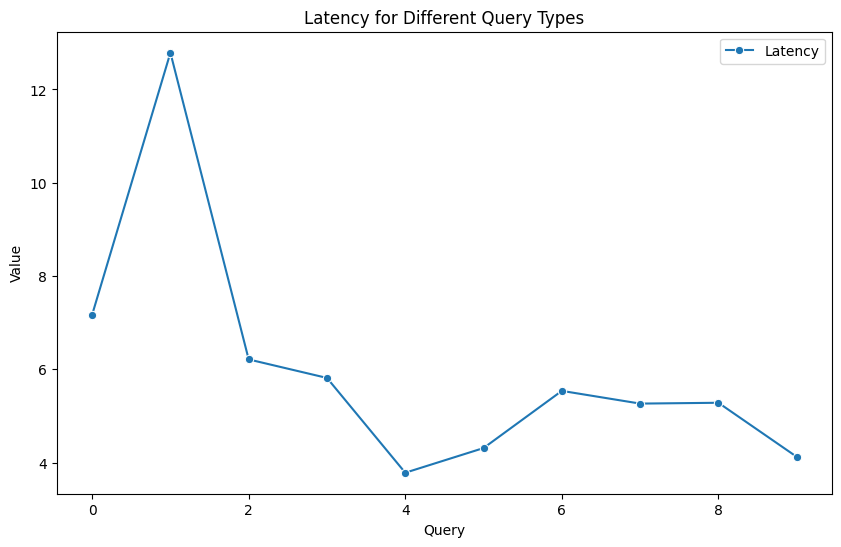

<Figure size 640x480 with 0 Axes>

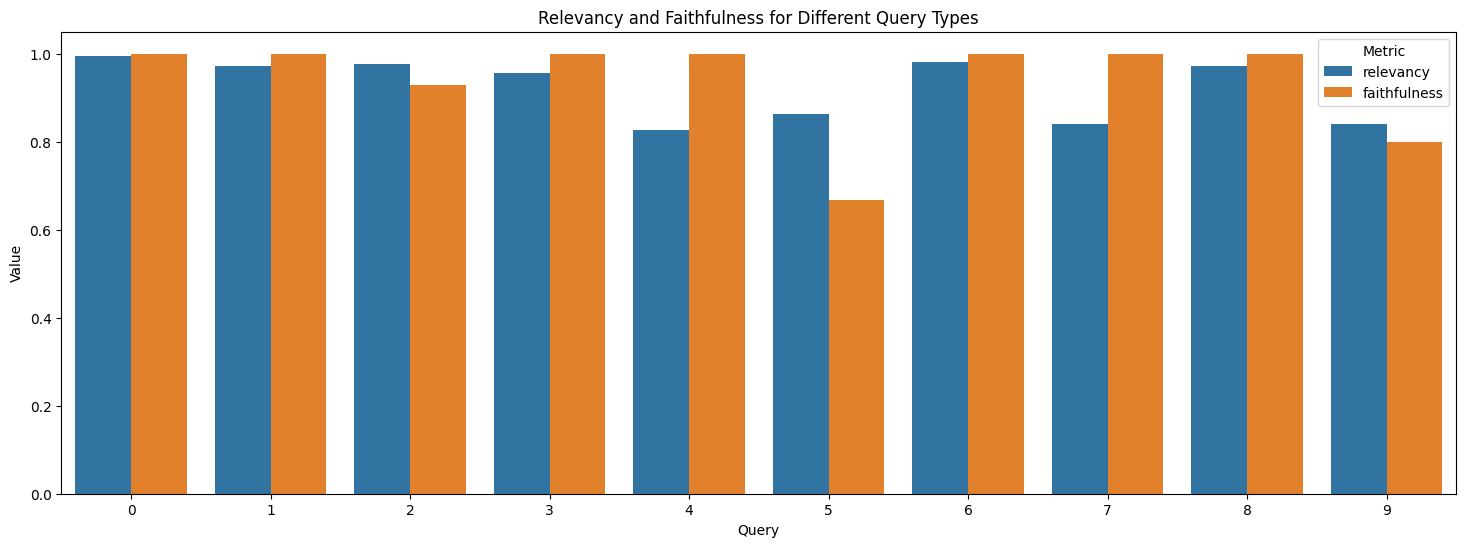

<Figure size 640x480 with 0 Axes>

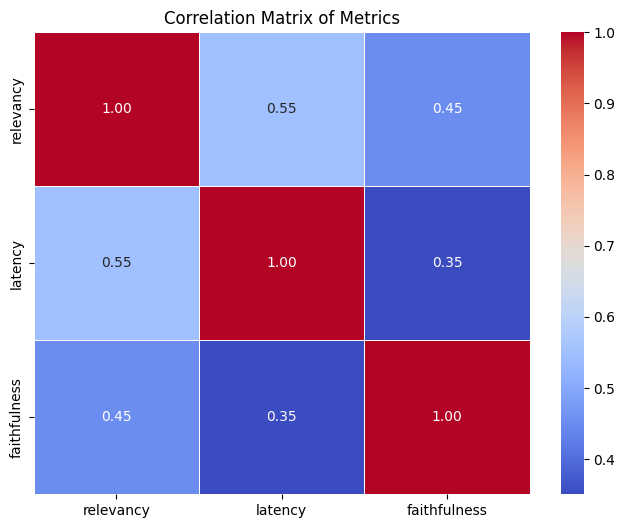

<Figure size 640x480 with 0 Axes>

In [8]:

data = {
    'query': [i for i in range(len(list(metrics['question'])))],
    'relevancy': list(metrics['answer_relevancy']),
    'latency': list(metrics['latency']),
    'faithfulness': list(metrics['faithfulness'])
}

df = pd.DataFrame(data)

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='query', y='latency', data=df, marker='o', label='Latency')
plt.xlabel('Query')
plt.ylabel('Value')
plt.title('Latency for Different Query Types')
plt.legend()
plt.savefig(wd+"\Images\plot1.png")
plt.show()
# Melt the DataFrame for easier plotting with Seaborn
df_melted = df.melt(id_vars='query', value_vars=['relevancy', 'faithfulness'], var_name='Metric', value_name='Value')

# Create a bar plot
plt.figure(figsize=(18, 6))
sns.barplot(x='query', y='Value', hue='Metric', data=df_melted)
plt.xlabel('Query')
plt.ylabel('Value')
plt.title('Relevancy and Faithfulness for Different Query Types')
plt.legend(title='Metric')
plt.savefig(wd+"\Images\plot2.png")
plt.show()

plt.figure(figsize=(8, 6))
correlation_matrix = df[['relevancy', 'latency', 'faithfulness']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.savefig(wd+"\Images\plot3.png")
plt.show()

## Conclusions from RAG Application Evaluation

### Overall System Effectiveness

- **Faithfulness**: The application shows strong performance in faithfulness, with scores ranging from 0.67 to 1.00. While most responses are highly accurate, there is a slight drop in faithfulness for some queries, indicating room for improvement in ensuring all answers closely align with the provided context.
- **Answer Relevancy**: The relevancy scores are consistently high, suggesting that the system is effective in delivering answers that are pertinent to the questions posed. The high relevancy scores demonstrate that the application is generally good at providing useful information based on the context.
- **Latency**: The response times vary between 3.38 and 6.38 seconds. While some queries are answered relatively quickly, others experience longer delays. Reducing latency, particularly for the slower responses, could enhance the user experience.

### Strengths

- **High Accuracy in Specific Categories**: The application excels in providing accurate answers for questions related to detective films (Q1) and heist/robbery movies (Q3), with perfect faithfulness and high relevancy scores. This indicates that the system performs particularly well for these types of queries.
- **Consistent Relevancy**: The overall high relevancy scores across different question types indicate that the application generally meets the user's needs effectively.

### Areas for Improvement

- **Faithfulness Variability**: The application has some lower faithfulness scores, particularly for queries about road trip movies (Q0) and love stories set during historical events (Q5). Analyzing and addressing the factors contributing to these discrepancies could improve the overall accuracy of responses.
- **Latency Optimization**: The variability in response times suggests the need for optimization. Investigating the causes of longer latency and implementing strategies to reduce processing time could improve overall efficiency.

### Suggestions for Future Enhancements

- **Fine-Tuning for Specific Query Types**: Focus on improving faithfulness and reducing latency for categories with lower performance scores. This could involve refining the algorithms or enhancing the underlying dataset.
- **Performance Monitoring**: Continuously monitor and analyze performance metrics to identify and address any emerging issues, ensuring the system remains responsive and accurate.


## References

1. **Evaluating RAG Applications with RAGAS**. (n.d.). Retrieved from [Towards Data Science](https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a#c52f)

2. **RAGAS Documentation**. (n.d.). Retrieved from [RAGAS Documentation](https://docs.ragas.io/en/stable/index.html)

3. **Optimizing RAG Applications: A Guide to Methodologies, Metrics, and Evaluation Tools**. (n.d.). Retrieved from [Medium](https://medium.com/@zilliz_learn/optimizing-rag-applications-a-guide-to-methodologies-metrics-and-evaluation-tools-for-enhanced-a9ae3d9c7149#:~:text=Ground%20truth%20metrics%20involve%20comparing,friendliness%2C%20harmfulness%2C%20and%20conciseness.)

4. **HumanFirst Blog on RAG Evaluation**. (n.d.). Retrieved from [HumanFirst](https://www.humanfirst.ai/blog/rag-evaluation)

5. **Neo4j GenAI Ecosystem**. (n.d.). Retrieved from [Neo4j](https://neo4j.com/labs/genai-ecosystem/#_neo4j_genai_features)

6. **YouTube Video on RAG Applications**. (n.d.). Retrieved from [YouTube](https://www.youtube.com/watch?v=SlMqsayqUHM)